# Python Driving License: Exam Project

Simone Caspani 

Cod: 10579585

PhD Chemical Engineering

In [1]:
# General import required in the solution

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
# Connect Aspen HYSYS and Python 

import os
import win32com.client as win32

# Obtain the path to the Aspen file
hyFilePath = os.path.abspath(r'C:\Users\scaspani\OneDrive - Politecnico di Milano\DOTTORATO\Corsi\Python_driving_license\Progetto\Milk_Pasteurization.hsc')

# Initialize  Aspen HYSYS application
print(' ')
print(' Connecting to the Aspen HYSYS.... Please wait ')
# This gets the registered name of Aspen HYSYS
HyApp = win32.Dispatch('HYSYS.Application')

HyCase = HyApp.SimulationCases.Open(hyFilePath)

# Aspen HYSYS File Name
HySysFile = HyCase.Title.Value
print(' ')
print('Aspen HYSYS file name:      ', HySysFile)

# Aspen HYSYS Thermodynamic Fluid Package Name
package_name = HyCase.Flowsheet.FluidPackage.PropertyPackageName
print('Aspen HYSYS Fluid Package:  ', package_name)
print(' ')

# Aspen HYSYS Material Streams Names
names = HyCase.Flowsheet.MaterialStreams.Names
print('Material streams names:     ')
print(names)
print(' ')

 
 Connecting to the Aspen HYSYS.... Please wait 
 
Aspen HYSYS file name:       Milk_Pasteurization.hsc
Aspen HYSYS Fluid Package:   Antoine
 
Material streams names:     
('Milk_NoPast', 'HW', 'Add_Water', '1', '2', 'Milk_Past', 'WW')
 


Aspen HYSYS flowsheet capture


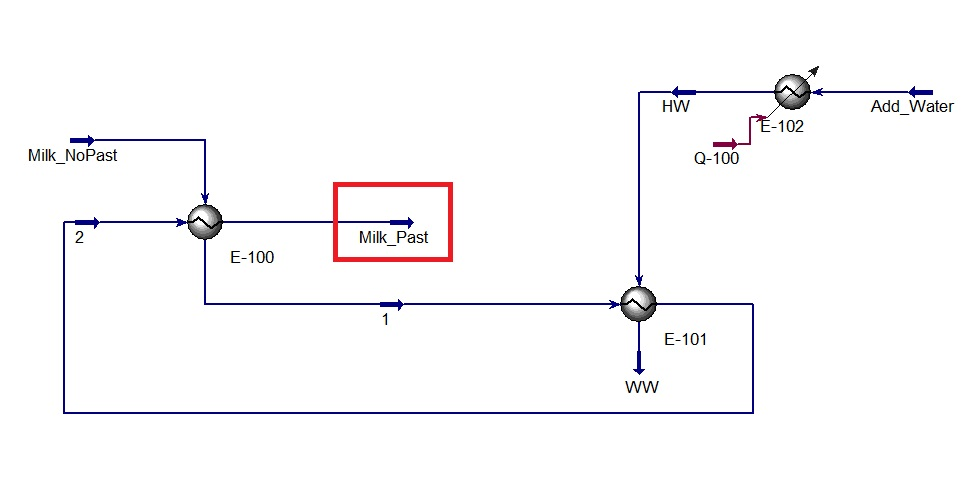

In [3]:
# Capture of the HYSYS scheme

print('\033[1m' + 'Aspen HYSYS flowsheet capture' + '\033[0m')
Image(r"C:\Users\scaspani\OneDrive - Politecnico di Milano\DOTTORATO\Corsi\Python_driving_license\Progetto\MilkPast.jpg")

In [4]:
# Extract the data from the material stream desired 

# Aspen HYSYS material stream, composition, Temperature and Pressure
# Components: H2O, Palmitic Acid, Oleic Acid, Calcium, Lactose, Potassium, Proline
components = ('H2O         ', 'PalmiticAcid', 'OleicAcid   ', 'Calcium     ', 'Lactose     ', 'Potassium   ', 'Proline     ')
k = len(components)

j = len(names)

a = input('Insert the name of the material stream you want info: ')
print(' ')

for i in range(0, j):

    if a == names[i]:
        
        Temperature = HyCase.Flowsheet.MaterialStreams.Item(names[i]).Temperature.getValue("K")
        Pressure = HyCase.Flowsheet.MaterialStreams.Item(names[i]).Pressure.getValue("atm")
        MassFlow = HyCase.Flowsheet.MaterialStreams.Item(names[i]).MassFlow.getValue("kg/h")
        Composition = HyCase.Flowsheet.MaterialStreams.Item(names[i]).ComponentMassFraction.Values

        print('Stream', '"', names[i], '"', 'temperature:        ', round(Temperature, 2), '   K')    
        print('Stream', '"', names[i], '"', 'pressure:           ', round(Pressure, 3), '     atm')
        print('Stream', '"', names[i], '"', 'mass flow:          ', round(MassFlow, 2), '  kg/h')
        print('')
        print('Stream', '"', names[i], '"', 'mass fraction composition:')


        for m in range(0, k):
            print(components[m], '        ', round(Composition[m],3), '   w/w')

Insert the name of the material stream you want info: Milk_Past
 
Stream " Milk_Past " temperature:         282.25    K
Stream " Milk_Past " pressure:            1.0      atm
Stream " Milk_Past " mass flow:           2000.0   kg/h

Stream " Milk_Past " mass fraction composition:
H2O                   0.909    w/w
PalmiticAcid          0.014    w/w
OleicAcid             0.014    w/w
Calcium               0.003    w/w
Lactose               0.033    w/w
Potassium             0.003    w/w
Proline               0.024    w/w


In [5]:
# ODE function modelling the spraydryer unit

def spraydryer(t, y, P, Gdry, A, B, C, rhoL, Kpw, nAvp, h, MWwater, MWair, dHev, CpL, CpG, rhoG, muG, dp, mp0, vg):
    
    mp, Gvap, Tp, Tg, vs, z = y
    
    Pw = MWair/MWwater*Gvap*P/Gdry
    P0 = np.exp(A-B/(Tp + C))/760
    Sp = np.pi*((mp/rhoL*6/np.pi)**(1/3))**2
    
    dmp = Kpw*Sp*(Pw - P0)
    dGvap = - Kpw*Sp*(Pw-P0)*nAvp
    dTp = (h*Sp*(Tg - Tp) + Kpw*Sp*(Pw-P0)*dHev)/mp/CpL
    dTg = - h*Sp*(Tg - Tp)*nAvp/(Gvap + Gdry)/CpG
    dvs = ((1 - rhoG/rhoL)*9.81 - 3*vs*muG*np.pi*dp/mp0)
    dz = vs + vg
    
    return dmp, dGvap, dTp, dTg, dvs, dz

In [6]:
# General Data and main script

# Imported data fropm HYSYS
Tp0 = Temperature                            # K
P = Pressure                                 # atm
MilkFlow = MassFlow                          # kg/h
wat_massfrac = Composition[0]                # w/w

# Physical properties
Tg0 = 403                                    # K
CpL = 1                                      # kcal/kg/K
CpG = 0.25                                   # kcal/kg/K
MWwater = 18                                 # kg/kmol
MWair = 29                                   # kg/kmol
R = 0.0821                                   # m^3*atm/K/kmol
dHev = 540                                   # kcal/kg
rhoL = 1000                                  # kg/m^3
rhoG = P/R/Tg0*MWair                         # kg/m^3
muG = 2.3*1e-5                               # kg/m/s
kG = 8*1e-6                                  # kcal/m/s/K
Diff = 1.8*1e-5                              # m^2/s

# Antoine's equation parameters
A = 18.3036
B = 3816.44
C = -46.13

# Process stream
Qmilk = MilkFlow/3600                        # kg/s
wat = wat_massfrac                           # w/w
Ql = Qmilk*wat                               # kg/s
Qfat = Qmilk - Ql                            # kg/s
Win = Ql/Qfat                                # kg(l)/kg(s)
Wout = 0.005                                 # kg(l)/kg(s)
dp = 2*1e-4                                  # m
vp0 = 0.3                                    # m/s
mp0 = rhoL*np.pi/6*dp**3                     # kg
mdry = mp0/(1+Win)                           # kg
mout = mdry*(1 + Wout)                       # kg
nAvp = Qmilk/mp0                             # drops/s

# Gas stream
Gdry = 20                                    # kg/s
D = 5.5                                      # m

# Momentum balance
vg = Gdry/rhoG/np.pi/D**2*4                  # m/s
vs = (rhoL - rhoG)*dp**2*9.81/18/muG         # m/s
vp = vg + vs                                 # m/s
vs0 = vp0 - vg                               # m/s

# Mass&Heat transfer
Re = rhoG*vs*dp/muG                          # Raynolds
Pr = muG*CpG/kG                              # Prandtl
Sc = muG/rhoG/Diff                           # Schmidt
Nu = 2 + 0.4*Re**0.5*Pr**(1/3)               # Nusselt
Sh = 2 + 0.4*Re**0.5*Sc**(1/3)               # Sherwood
h = Nu*kG/dp                                 # kcal/m^2/s/K
Kc = Sh*Diff/dp                              # m/s
Kpw = Kc/R/Tg0*MWwater                       # kg/m^2/s/atm

In [7]:
# ODE solver

y0 = [mp0, 0, Tp0, Tg0, vs0, 0]
tspan = [0, 10]

sol = solve_ivp(spraydryer, tspan, y0, method = 'BDF', t_eval = None, args = (P, Gdry, A, B, C, rhoL, Kpw, nAvp, h, MWwater, MWair, dHev, CpL, CpG, rhoG, muG, dp, mp0, vg))

mp, Gvap, Tp, Tg, vs, z = sol.y

a = len(sol.t)

q = np.where(mp < mout)
q = q[0]
q = q[0]
p = sol.t[-1]

Unit sizing:
Shape:                Cylindrical
Residence time:       6.22   s
Height:               11.71  m
Diameter:             5.5    m
Volume:               278.22 m^3

Plots:


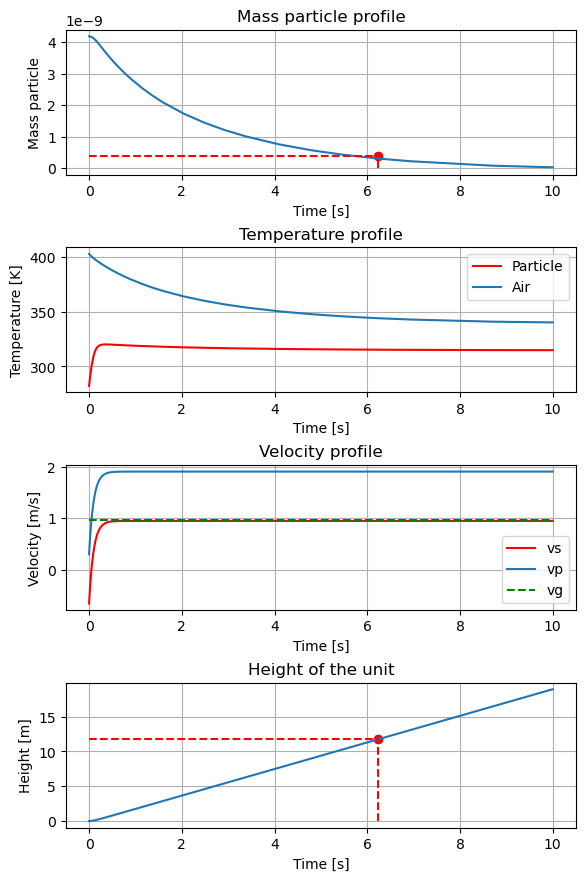

In [8]:
# Results and plots

time = sol.t[q]
height = z[q]

print('\033[1m' + 'Unit sizing:' + '\033[0m')
print('Shape:               ', 'Cylindrical')
print('Residence time:      ', round(time,2), '  s')
print('Height:              ', round(height,2), ' m')
print('Diameter:            ', D, '   m')
Volume = np.pi/4*D**2*height
print('Volume:              ', round(Volume,2), 'm^3')

print('')
print('\033[1m' + 'Plots:' + '\033[0m')

plt.figure(figsize=(6, 9.5))

plt.subplot(411)
plt.title('Mass particle profile')
plt.plot(sol.t, mp)
plt.hlines(y = mout, xmin = 0, xmax = time, color = 'r', linestyles='--')
plt.vlines(x = time, ymin = 0, ymax = mout, color = 'r', linestyles='--')
plt.scatter(sol.t[q], mout, color = 'r')
plt.xlabel('Time [s]')
plt.ylabel('Mass particle')
plt.grid()

plt.subplot(412)
plt.title('Temperature profile')
plt.plot(sol.t, Tp, 'r', label = 'Particle')
plt.plot(sol.t, Tg,  label = 'Air')
plt.xlabel('Time [s]')
plt.ylabel('Temperature [K]')
plt.legend(loc = 0)
plt.grid()

plt.subplot(413)
plt.title('Velocity profile')
plt.plot(sol.t, vs, 'r', label = 'vs')
plt.plot(sol.t, vg + vs, label = 'vp')
plt.hlines(y = vg, xmin = 0, xmax = p, color = 'g', linestyle = 'dashed', label = 'vg')
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.legend(loc = 0)
plt.grid()

plt.subplot(414)
plt.title('Height of the unit')
plt.plot(sol.t, z)
plt.scatter(sol.t[q], height, color = 'r')
plt.hlines(y = height, xmin = 0, xmax = time, color = 'r', linestyles='--')
plt.vlines(x = time, ymin = 0, ymax = height, color = 'r', linestyles='--')
plt.xlabel('Time [s]')
plt.ylabel('Height [m]')
plt.grid()

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.5)
plt.show()